## 数据爬取

### 爬取项目概况
包括项目ID、项目标题、项目链接、项目封面图片链接、筹款金额、支持者数量、筹款百分比、创建者信息（名称、头像链接）

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [2]:
# 基础URL，页码将被替换
base_url = 'https://zhongchou.modian.com/food/top_comment/all/'

# 用于存储提取的数据
project_data = []

# 循环遍历每一页
for page_num in range(1, 55):  # 一共54页，从1页到54页
    # 构造每一页的URL
    url = f'{base_url}{page_num}'
    
    # 发送GET请求并获取页面内容
    response = requests.get(url)
    html = response.text

    # 使用BeautifulSoup解析HTML
    soup = BeautifulSoup(html, 'html.parser')

    # 获取所有项目卡片
    project_list = soup.find_all('li', class_='pc_ga_pro_index_18')

    # 遍历每个项目卡片，提取相关数据
    for project in project_list:
        project_info = {}
    
        # 获取项目ID
        project_id = project.get('data-pro-id')
        project_info['项目ID'] = project_id if project_id else None

        # 获取项目标题
        title = project.find('h3', class_='pro_title')
        project_info['项目名称'] = title.get_text(strip=True) if title else None
    
        # 获取项目链接
        link = project.find('a', href=True)
        project_info['项目链接'] = link['href'] if link else None
    
        # 获取项目封面图片
        img = project.find('img', alt=True)
        project_info['项目图片'] = img['src'] if img else None
    
        # 获取筹款金额
        amount = project.find('span', {'backer_money': True})
        if amount:
            amount_text = amount.get_text(strip=True)
            # 去除千分位分隔符并转为浮点数
            project_info['筹款金额'] = float(amount_text.replace(',', ''))
        else:
            project_info['筹款金额'] = None
    
        # 获取百分比
        percent = project.find('span', {'rate': True})
        if percent:
            project_info['筹款百分比'] = float(percent.get_text(strip=True))
        else:
            project_info['筹款百分比'] = None

        # 获取支持者人数
        backer_count = project.find('span', {'backer_count': True})
        if backer_count:
            project_info['支持者数量'] = int(backer_count.get_text(strip=True))
        else:
            project_info['支持者数量'] = None
    
        # 获取创建者信息
        author = project.find('div', class_='author')
        if author:
            author_name = author.find('p')
            author_avatar = author.find('div', class_='au_logo')
            project_info['创建者'] = author_name.get_text(strip=True) if author_name else None
            project_info['创建者头像'] = author_avatar['style'].split('background: url(')[1].split(')')[0] if author_avatar else None
        else:
            project_info['创建者'] = None
            project_info['创建者头像'] = None
    
        # 将项目数据加入列表
        project_data.append(project_info)

In [3]:
# 将数据转为DataFrame, 并查看数据信息
df1 = pd.DataFrame(project_data)
df1.to_excel('项目概况.xlsx', index=False)

### 爬取项目详情页
包括项目项目详情图片、项目奖励图片、是否有视频、项目状态、筹款金额、目标金额、筹款百分比、支持者数量、项目更新数量、回报选项数量

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
from urllib.parse import urljoin
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from tqdm import tqdm

# Selenium 配置
chrome_options = Options()
chrome_options.add_argument("--headless")  # 无头模式，隐藏浏览器窗口
chrome_options.add_argument("--disable-gpu")  # 禁用 GPU 加速
chrome_options.add_argument("--no-sandbox")  # 解决沙箱问题
chrome_options.add_argument("--disable-dev-shm-usage")  # 防止资源限制问题
driver_path = 'C:/Users/zwf/anaconda3/chromedriver.exe'
service = Service(driver_path)


In [5]:
# 读取 Excel 文件
excel_path = '项目概况.xlsx'
data = pd.read_excel(excel_path)
project_links = data['项目链接']

# 定义保存路径
output_dir = '项目图片'
os.makedirs(output_dir, exist_ok=True)

# 项目详情图文件夹
project_details_dir = os.path.join(output_dir, '项目详情')
os.makedirs(project_details_dir, exist_ok=True)

# 奖励展示图文件夹
reward_display_dir = os.path.join(output_dir, '奖励展示')
os.makedirs(reward_display_dir, exist_ok=True)

# 初始化存储爬取结果的列表
results = []

# 图片下载函数
def download_image(img_url, save_path):
    try:
        response = requests.get(img_url, timeout=10)
        response.raise_for_status()
        with open(save_path, 'wb') as f:
            f.write(response.content)
    except Exception as e:
        print(f"下载图片失败：{img_url}，错误：{e}")

# 图片下载
def download_images(img_elements, project_dir, prefix, link):
    for i, img in enumerate(img_elements):
        img_url = img.get('data-src') or img.get('src')
        if not img_url:
            continue
        img_url = urljoin(link, img_url)
        save_path = os.path.join(project_dir, f'{prefix}_image_{i}.jpg')
        download_image(img_url, save_path)

# 爬取单个项目数据
def fetch_project_data(link):
    driver = webdriver.Chrome(service=service, options=chrome_options)
    project_data = {'项目ID': os.path.basename(link).strip()}  # 提取项目ID并初始化字典
    try:
        driver.get(link)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div.center'))
        )
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # 筹款金额
        amount_raised_element = soup.select_one('div.center > div.center-top > div.col1.project-goal.success > h3 > span')
        project_data['筹款金额'] = float(amount_raised_element.text.strip().replace(',', '')) if amount_raised_element else None

        # 目标金额
        goal_amount_element = soup.select_one(
            'div.center > div.center-top > div.col1.project-goal.success > p.txt.clearfloat > span.goal-money'
        )
        project_data['目标金额'] = float(re.sub(r'[^\d.]', '', goal_amount_element.text.strip())) if goal_amount_element else None

        # 筹款百分比
        percentage_element = soup.select_one(
            'div.center > div.center-top > div.col1.project-goal.success > p.txt.clearfloat > span.percent'
        )
        project_data['筹款百分比'] = float(re.sub(r'%', '', percentage_element.text.strip())) if percentage_element else None

        # 支持者数量
        supporters_element = soup.select_one('div.col3.support-people > h3 > span')
        project_data['支持者数量'] = int(supporters_element.text.strip().replace(',', '')) if supporters_element else None

        # 更新数量
        updates_element = soup.select_one('li.pro-gengxin > span')
        project_data['更新数量'] = int(updates_element.text.strip()) if updates_element else 0

        # 回报选项数量
        reward_menu_element = soup.select_one('div.payback-lists.margin36.nobtn')
        project_data['回报选项数量'] = len(reward_menu_element.find_all('div', recursive=False)) if reward_menu_element else 0

        # 是否有视频
        video_element = soup.select_one('p.vedio_url')
        project_data['是否有视频'] = 0 if video_element and video_element.get('data-duration', '0') == '0' else 1

        # 项目状态
        status_element = soup.select_one('div.tanchuzhuangtai')
        project_data['项目状态'] = status_element.get('status', None) if status_element else None

        # 当前项目文件夹
        project_name = os.path.basename(link).strip()
        project_name = re.sub(r'\.html$', '', project_name)
        details_project_dir = os.path.join(project_details_dir, project_name)
        rewards_project_dir = os.path.join(reward_display_dir, project_name)

        os.makedirs(details_project_dir, exist_ok=True)
        os.makedirs(rewards_project_dir, exist_ok=True)

        # 下载项目详情图片
        detail_img_elements = soup.select('div#projectDetail img')
        download_images(detail_img_elements, details_project_dir, "detail", link)

        # 下载奖励展示图片
        reward_img_elements = soup.select('div.back-img-item img.lazy')
        download_images(reward_img_elements, rewards_project_dir, "reward", link)

    except Exception as e:
        print(f"爬取失败，项目链接：{link}，错误：{e}")
    finally:
        driver.quit()
    return project_data

# 顺序处理所有项目
for link in tqdm(project_links, desc="爬取项目进度"):
    try:
        project_data = fetch_project_data(link)
        if project_data:
            results.append(project_data)
    except Exception as e:
        print(f"爬取失败，项目链接：{link}，错误：{e}")

# 保存为 Excel
output_file = '项目具体数据.xlsx'
pd.DataFrame(results).to_excel(output_file, index=False)
print(f"爬取完成，数据保存为 {output_file}")


爬取项目进度:  11%|█▏        | 73/638 [10:48<1:21:19,  8.64s/it]

下载图片失败：http://testp.modianinc.com/project/2021/03/08/20210308_1615172745_9533.jpg?imageMogr2/auto-orient/strip?/width750/height316，错误：502 Server Error: Bad Gateway for url: http://testp.modianinc.com/project/2021/03/08/20210308_1615172745_9533.jpg?imageMogr2/auto-orient/strip?/width750/height316


爬取项目进度:  54%|█████▎    | 342/638 [49:26<32:19,  6.55s/it]  

下载图片失败：https://p6.moimg.net/ueditor/image/2020/06/19/1592534936638038.jpg?imageMogr2/auto-orient/strip?/width690/height750，错误：HTTPSConnectionPool(host='p6.moimg.net', port=443): Max retries exceeded with url: /ueditor/image/2020/06/19/1592534936638038.jpg?imageMogr2/auto-orient/strip?/width690/height750 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))


爬取项目进度:  74%|███████▎  | 470/638 [1:05:44<19:38,  7.01s/it]

下载图片失败：http://testp.modianinc.com/project/2021/01/15/20210115_1610704208_4383.jpg?imageMogr2/auto-orient/strip?/width750/height900，错误：502 Server Error: Bad Gateway for url: http://testp.modianinc.com/project/2021/01/15/20210115_1610704208_4383.jpg?imageMogr2/auto-orient/strip?/width750/height900


爬取项目进度:  80%|███████▉  | 510/638 [1:12:17<52:09, 24.45s/it]

爬取失败，项目链接：https://zhongchou.modian.com/item/126229.html，错误：Message: chrome not reachable
Stacktrace:
Backtrace:
	GetHandleVerifier [0x008DA813+48355]
	(No symbol) [0x0086C4B1]
	(No symbol) [0x00775220]
	(No symbol) [0x0076B355]
	(No symbol) [0x00795C68]
	(No symbol) [0x00791EF3]
	(No symbol) [0x00790579]
	(No symbol) [0x007C0C55]
	(No symbol) [0x007C093C]
	(No symbol) [0x007BA536]
	(No symbol) [0x007982DC]
	(No symbol) [0x007993DD]
	GetHandleVerifier [0x00B3AABD+2539405]
	GetHandleVerifier [0x00B7A78F+2800735]
	GetHandleVerifier [0x00B7456C+2775612]
	GetHandleVerifier [0x009651E0+616112]
	(No symbol) [0x00875F8C]
	(No symbol) [0x00872328]
	(No symbol) [0x0087240B]
	(No symbol) [0x00864FF7]
	BaseThreadInitThunk [0x753E5D49+25]
	RtlInitializeExceptionChain [0x76F9BD6B+107]
	RtlGetAppContainerNamedObjectPath [0x76F9BCF1+561]



爬取项目进度:  88%|████████▊ | 562/638 [1:18:59<10:31,  8.30s/it]

下载图片失败：https://p6.moimg.net/path/dst_project/202206/1517/1031/22061510318R7OwWrLPJm0zgew1aEonZY5MQNVjg.png，错误：HTTPSConnectionPool(host='p6.moimg.net', port=443): Max retries exceeded with url: /path/dst_project/202206/1517/1031/22061510318R7OwWrLPJm0zgew1aEonZY5MQNVjg.png (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))


爬取项目进度: 100%|██████████| 638/638 [1:28:54<00:00,  8.36s/it]

爬取完成，数据保存为 项目具体数据.xlsx


### 在Excel文件里面加入图片路径

In [6]:
import os
import pandas as pd

data = pd.read_excel(r"D:\PycharmProjects\MISreport\项目具体数据.xlsx")

# 定义奖励和详情图片的路径格式
reward_base_path = r"D:\PycharmProjects\MISreport\项目图片\奖励展示"
detail_base_path = r"D:\PycharmProjects\MISreport\项目图片\项目详情"

# 添加图片路径
data['奖励图片路径'] = data['项目ID'].apply(lambda x: os.path.join(reward_base_path, f"{x}"))
data['详情图片路径'] = data['项目ID'].apply(lambda x: os.path.join(detail_base_path, f"{x}"))

# 将带路径的表格导出
data.to_excel(r"D:\PycharmProjects\MISreport\项目具体数据-路径.xlsx", index=False)

### 计算图片清晰度

In [7]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from tqdm import tqdm

# 计算图片清晰度
def calculate_blurriness(image_path):
    try:
        with Image.open(image_path) as img:
            gray_image = img.convert('L')
            image_array = np.array(gray_image)
            laplacian_var = np.var(np.gradient(image_array))
            return laplacian_var
    except Exception as e:
        print(f"Error processing image for blurriness: {e}")
        return None

### 计算图片亮度

In [8]:
# 计算图片亮度
def calculate_brightness(image_path):
    try:
        with Image.open(image_path) as img:
            hsv_image = img.convert('HSV')
            v_channel = np.array(hsv_image)[:, :, 2]
            brightness = v_channel.mean()
            return brightness
    except Exception as e:
        print(f"Error processing image for brightness: {e}")
        return None


### 提取图片主色调

In [9]:
# 提取图片主色调
def extract_dominant_colors(image_path, k=3):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            pixels = np.array(img).reshape(-1, 3)
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(pixels)
            dominant_colors = kmeans.cluster_centers_
            return dominant_colors.mean(axis=0)  # 返回主色调的平均值
    except Exception as e:
        print(f"Error processing image for dominant colors: {e}")
        return None

### 计算图片中人脸数量

In [10]:
# 加载预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# 使用 Pillow 加载图片并检测人脸
def detect_faces_with_pillow(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')  # 转换为 RGB 模式
            image_array = np.array(img)  # 转换为 NumPy 数组
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)  # 转换为灰度图
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        return len(faces)  # 返回检测到的人脸数量
    except Exception as e:
        print(f"Error processing image for face detection: {e}")
        return 0

### 综合所有图片特征

In [11]:
# 聚合单个项目的图片特征
def aggregate_project_features(project_path):
    image_paths = [os.path.join(project_path, img) for img in os.listdir(project_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    blurriness_values = []
    brightness_values = []
    color_features = []
    face_counts = 0

    for image_path in image_paths:
        blurriness = calculate_blurriness(image_path)
        brightness = calculate_brightness(image_path)
        color_feature = extract_dominant_colors(image_path)
        face_count = detect_faces_with_pillow(image_path)  # 调用 Pillow 和 OpenCV 结合的检测方法
        
        if blurriness is not None:
            blurriness_values.append(blurriness)
        if brightness is not None:
            brightness_values.append(brightness)
        if color_feature is not None:
            color_features.append(color_feature)
        face_counts += face_count

    return {
        "平均清晰度": np.mean(blurriness_values) if blurriness_values else None,
        "平均亮度": np.mean(brightness_values) if brightness_values else None,
        "主色调": np.mean(color_features, axis=0).tolist() if color_features else None,
        "人脸总数": face_counts,  # 返回项目所有图片的人脸总数
    }

In [12]:
# 遍历所有项目并计算特征
def process_all_projects(base_path):
    project_types = ["项目详情", "奖励展示"]
    results = {ptype: {} for ptype in project_types}

    for ptype in project_types:
        project_folder = os.path.join(base_path, ptype)
        for project_id in tqdm(os.listdir(project_folder), desc=f"Processing {ptype}"):
            project_path = os.path.join(project_folder, project_id)
            results[ptype][project_id] = aggregate_project_features(project_path)

    return results

### 利用主色调向量计算详情图片和奖励图片的色彩相似度

In [13]:
# 计算详情图片与奖励图片的相似性
def calculate_project_similarities(detail_features, reward_features):
    similarities = {}
    for project_id in detail_features:
        if project_id in reward_features:
            detail_color = detail_features[project_id].get("主色调")
            reward_color = reward_features[project_id].get("主色调")
            if detail_color and reward_color:
                similarity = cosine_similarity([detail_color], [reward_color])[0][0]
                similarities[project_id] = similarity
            else:
                similarities[project_id] = None
    return similarities

### 调用主函数

In [14]:
# 主函数
def main():
    base_path = "项目图片"
    # 处理所有项目，计算特征
    all_features = process_all_projects(base_path)
    detail_features = all_features["项目详情"]
    reward_features = all_features["奖励展示"]

    # 计算详情图片与奖励图片的相似性
    similarities = calculate_project_similarities(detail_features, reward_features)

    # 转换为 DataFrame 并保存结果
    detail_df = pd.DataFrame.from_dict(detail_features, orient="index")
    reward_df = pd.DataFrame.from_dict(reward_features, orient="index")
    similarity_df = pd.DataFrame.from_dict(similarities, orient="index", columns=["相似度"])

    # 保存到 Excel
    with pd.ExcelWriter("全部数据.xlsx") as writer:
        detail_df.to_excel(writer, sheet_name="详情图片特征")
        reward_df.to_excel(writer, sheet_name="奖励图片特征")
        similarity_df.to_excel(writer, sheet_name="相似度")

    print("分析结果已保存到全部数据.xlsx")

if __name__ == "__main__":
    main()


Processing 项目详情:   0%|          | 0/637 [00:00<?, ?it/s]c:\Users\zwf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\zwf\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\zwf\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zwf\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\zwf\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _

Error processing image for blurriness: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Error processing image for dominant colors: n_samples=1 should be >= n_clusters=3.


Processing 项目详情:   7%|▋         | 44/637 [07:12<1:41:46, 10.30s/it]c:\Users\zwf\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\zwf\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing 项目详情:  12%|█▏        | 74/637 [12:54<2:09:58, 13.85s/it]c:\Users\zwf\anaconda3\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Processing 项目详情:  13%|█▎        | 85/637 [14:40<1:28:46,  9.65s/it]

Error processing image for blurriness: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Error processing image for dominant colors: n_samples=1 should be >= n_clusters=3.


Processing 项目详情:  15%|█▍        | 94/637 [15:50<56:32,  6.25s/it]  c:\Users\zwf\anaconda3\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Processing 项目详情:  44%|████▍     | 279/637 [43:53<1:02:13, 10.43s/it]c:\Users\zwf\anaconda3\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Processing 项目详情:  49%|████▉     | 314/637 [49:13<1:09:16, 12.87s/it]c:\Users\zwf\anaconda3\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Processing 项目详情:  88%|████████▊ | 559/637 [1:28:03<14:24, 11.08s/it]

Error processing image for blurriness: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
Error processing image for dominant colors: n_samples=1 should be >= n_clusters=3.


Processing 项目详情:  91%|█████████ | 578/637 [1:32:13<23:42, 24.11s/it]

Error processing image for blurriness: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.


c:\Users\zwf\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Error processing image for blurriness: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.


c:\Users\zwf\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
Processing 奖励展示: 100%|██████████| 637/637 [28:51<00:00,  2.72s/it]  


分析结果已保存到全部数据.xlsx


### 检查全部数据，初步清洗并导出

In [17]:
df2 = pd.read_excel(r"D:\PycharmProjects\MISreport\全部数据-副本.xlsx")

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   项目ID    637 non-null    int64  
 1   筹款金额    637 non-null    float64
 2   目标金额    637 non-null    float64
 3   筹款百分比   637 non-null    float64
 4   支持者数量   637 non-null    int64  
 5   更新数量    637 non-null    int64  
 6   回报选项数量  637 non-null    int64  
 7   是否有视频   637 non-null    int64  
 8   项目状态    637 non-null    object 
 9   清晰度     637 non-null    float64
 10  亮度      637 non-null    float64
 11  人脸总数    637 non-null    int64  
 12  相似度     523 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 64.8+ KB


In [19]:
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523 entries, 0 to 635
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   项目ID    523 non-null    int64  
 1   筹款金额    523 non-null    float64
 2   目标金额    523 non-null    float64
 3   筹款百分比   523 non-null    float64
 4   支持者数量   523 non-null    int64  
 5   更新数量    523 non-null    int64  
 6   回报选项数量  523 non-null    int64  
 7   是否有视频   523 non-null    int64  
 8   项目状态    523 non-null    object 
 9   清晰度     523 non-null    float64
 10  亮度      523 non-null    float64
 11  人脸总数    523 non-null    int64  
 12  相似度     523 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 57.2+ KB


In [20]:
df2.to_excel(r"D:\PycharmProjects\MISreport\全部数据-副本.xlsx", index=False)

# 数据分析

## 导入数据

In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df3 = pd.read_excel(r"D:\PycharmProjects\MISreport\全部数据-副本.xlsx",
                     usecols=['项目状态', '筹款金额', '筹款百分比', '支持者数量', '目标金额', 
                              '是否有视频', '更新数量', '回报选项数量', 
                              '清晰度', '亮度', '人脸总数', '相似度'])

df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   项目状态    523 non-null    object 
 1   筹款金额    523 non-null    float64
 2   筹款百分比   523 non-null    float64
 3   支持者数量   523 non-null    int64  
 4   目标金额    523 non-null    float64
 5   更新数量    523 non-null    int64  
 6   回报选项数量  523 non-null    int64  
 7   是否有视频   523 non-null    int64  
 8   清晰度     523 non-null    float64
 9   亮度      523 non-null    float64
 10  相似度     523 non-null    float64
 11  人脸总数    523 non-null    int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 49.2+ KB


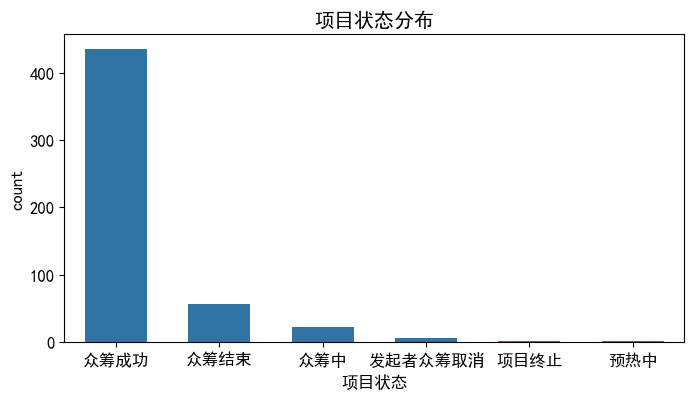

In [267]:
# 状态分布
# 绘制状态分布图
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 4))
# 按值大小排序
order = df3['项目状态'].value_counts().index
sns.countplot(data=df3, x='项目状态', order=order, width=0.6)
plt.title("项目状态分布")  # 设置字体大小
plt.show()

In [268]:
# 是否成功
df3['是否成功'] = df3['项目状态'].apply(lambda x: 1 if x == '众筹成功' else 0)

In [269]:
# 分离成功和失败的项目
success_projects = df3[df3['是否成功'] == 1]
failed_projects = df3[df3['是否成功'] == 0]

# 定义异常值的过滤条件（高于 50% 分位数）
amount_threshold = success_projects['筹款金额'].quantile(0.5)
percentage_threshold = success_projects['筹款百分比'].quantile(0.5)
goal_threshold = success_projects['目标金额'].quantile(0.5)


# 删除满足任意条件的记录
filtered_success_projects = success_projects[
    ~(
        (success_projects['筹款金额'] > amount_threshold) |
        (success_projects['筹款百分比'] > percentage_threshold) |
        (success_projects['目标金额'] > goal_threshold)
    )
]

# 定义失败项目的过滤条件（高于 90% 分位数）
goal_threshold_failed = failed_projects['目标金额'].quantile(0.90)

# 删除目标金额过大的失败项目
filtered_failed_projects = failed_projects[
    failed_projects['目标金额'] <= goal_threshold_failed
]


# 合并所有失败项目和筛选后的成功项目
balanced_data = pd.concat([filtered_success_projects, filtered_failed_projects], ignore_index=True)

# 检查结果数据集的信息
balanced_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   项目状态    215 non-null    object 
 1   筹款金额    215 non-null    float64
 2   筹款百分比   215 non-null    float64
 3   支持者数量   215 non-null    int64  
 4   目标金额    215 non-null    float64
 5   更新数量    215 non-null    int64  
 6   回报选项数量  215 non-null    int64  
 7   是否有视频   215 non-null    int64  
 8   清晰度     215 non-null    float64
 9   亮度      215 non-null    float64
 10  相似度     215 non-null    float64
 11  人脸总数    215 non-null    int64  
 12  是否成功    215 non-null    int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 22.0+ KB


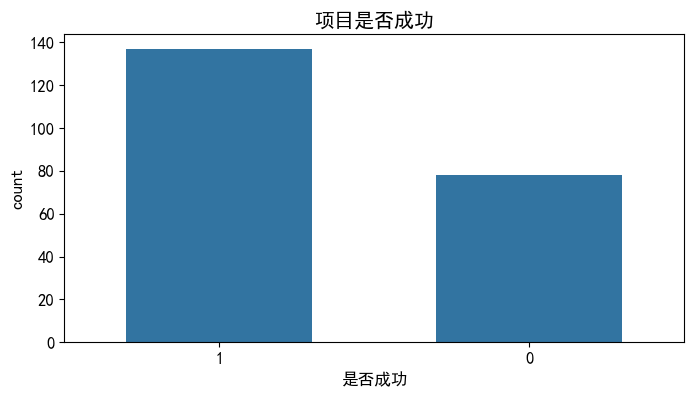

In [270]:
# 状态分布
# 绘制状态分布图
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 4))
# 按值大小排序
order = balanced_data['是否成功'].value_counts().index
sns.countplot(data=balanced_data, x='是否成功', order=order, width=0.6)
plt.title("项目是否成功") 
plt.show()

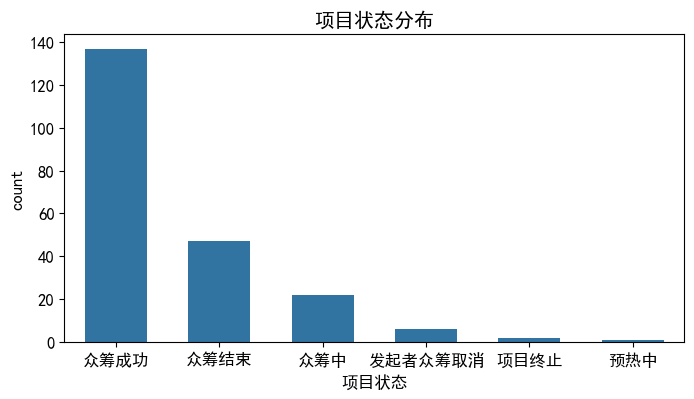

In [271]:
# 状态分布
# 绘制状态分布图
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 4))
# 按值大小排序
order = balanced_data['项目状态'].value_counts().index
sns.countplot(data=balanced_data, x='项目状态', order=order, width=0.6)
plt.title("项目状态分布") 
plt.show()

In [272]:
# 保存平衡后的数据
balanced_file_path = '平衡数据集.xlsx'
balanced_data.to_excel(balanced_file_path, index=False)

## 描述性统计

In [355]:
df4 = pd.read_excel(r"D:\PycharmProjects\MISreport\平衡数据集.xlsx")

In [356]:
# 对所有数值型列进行描述性统计
descriptive_stats = df4.describe().round(2)

# 显示描述性统计结果
descriptive_stats

,筹款金额,筹款百分比,支持者数量,目标金额,更新数量,回报选项数量,是否有视频,清晰度,亮度,相似度,人脸总数,是否成功
count,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00,215.00
mean,5797.30,170.03,50.84,5684.65,2.89,4.55,0.07,245.69,190.45,1.00,10.07,0.64
std,4355.41,201.45,55.00,6933.17,3.18,3.54,0.25,109.21,38.61,0.01,10.11,0.48
min,0.00,0.00,0.00,1000.00,0.00,0.00,0.00,59.25,33.22,0.94,0.00,0.00
25%,2179.00,46.26,9.50,2000.00,1.00,0.00,0.00,170.40,175.67,1.00,5.00,0.00
50%,5425.72,135.10,32.00,5000.00,2.00,5.00,0.00,226.55,201.92,1.00,7.00,1.00
75%,8352.50,239.07,81.00,5000.00,4.00,7.00,0.00,305.98,218.95,1.00,12.00,1.00
max,24728.00,2472.80,331.00,40000.00,20.00,14.00,1.00,697.93,240.60,1.00,77.00,1.00


## 数据可视化

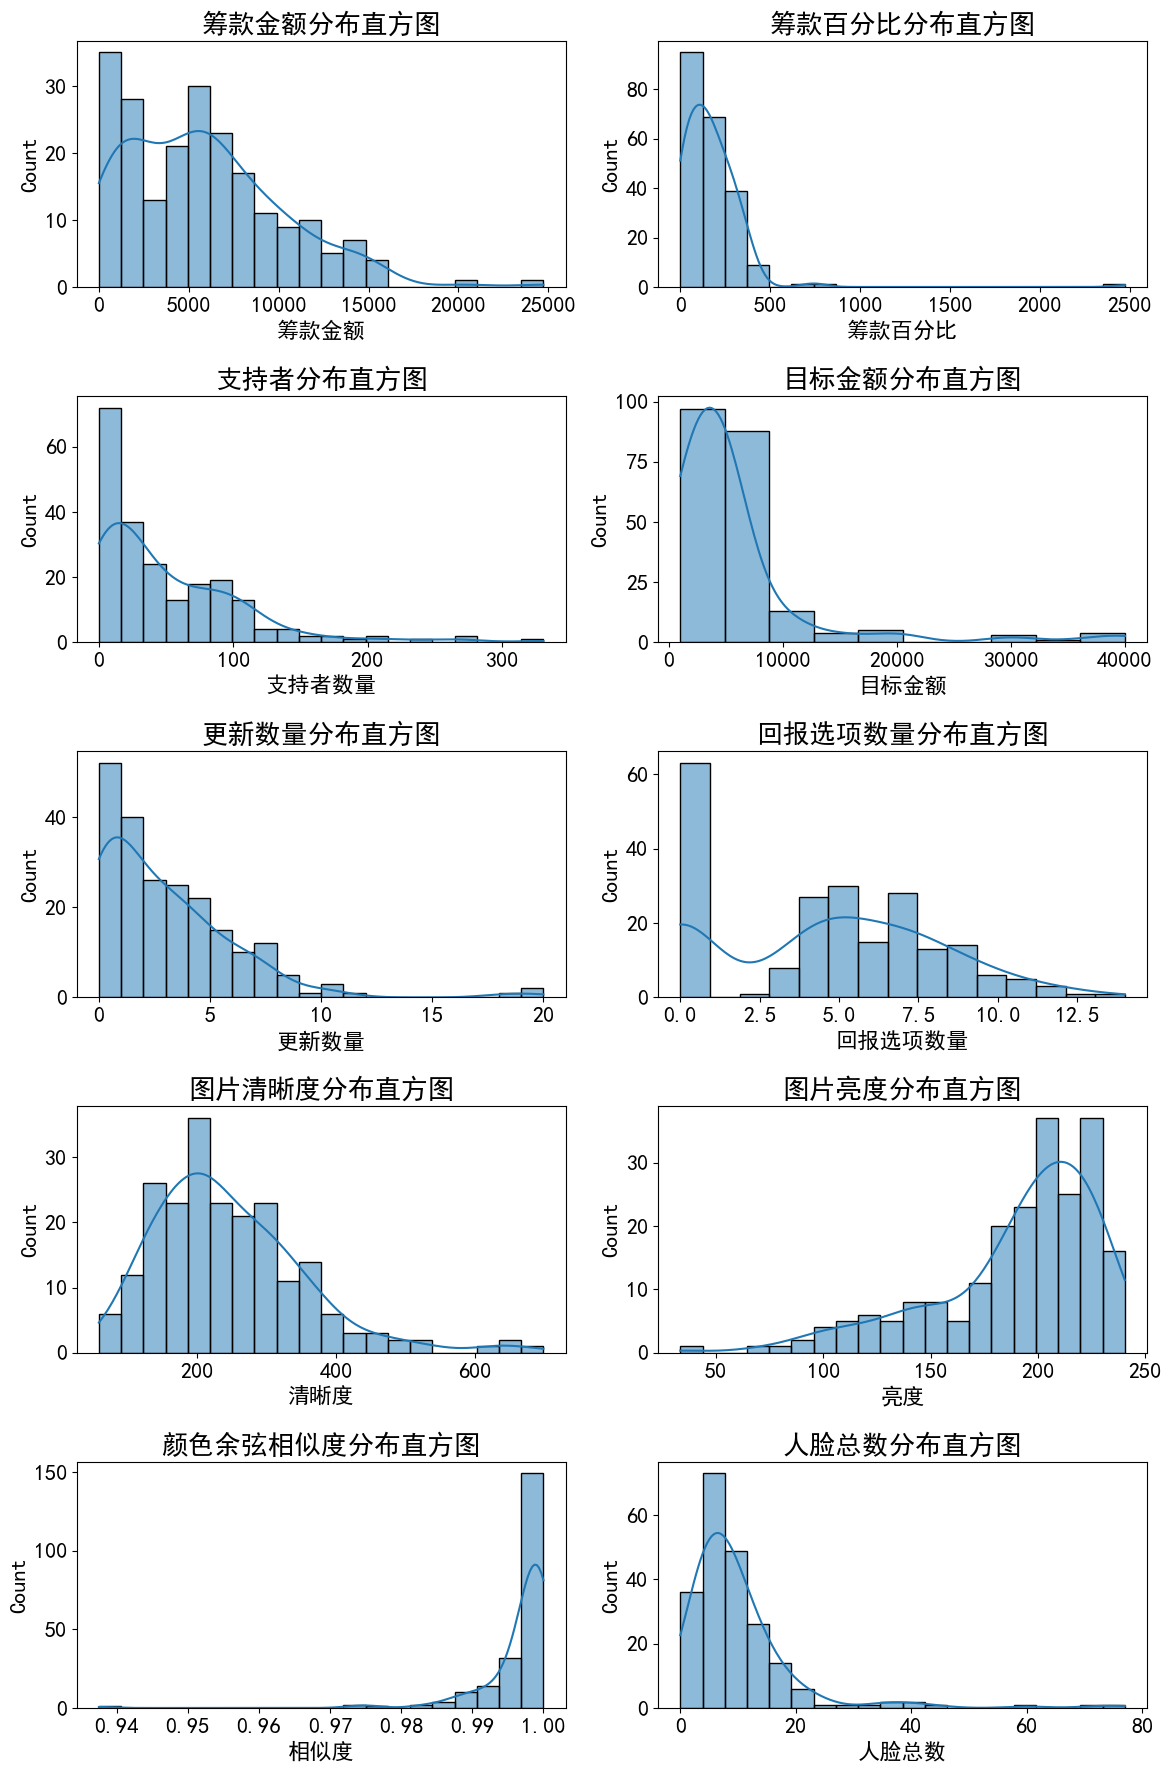

In [357]:
# 绘制支持者人数、筹款金额、图片清晰度、亮度等的分布图
fig, axes = plt.subplots(5, 2, figsize=(12, 18))
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams.update({'font.size': 16})  # 设置字体大小

sns.histplot(df4['筹款金额'], bins=20, kde=True, ax=axes[0, 0]).set_title("筹款金额分布直方图")
sns.histplot(df4['筹款百分比'], bins=20, kde=True, ax=axes[0, 1]).set_title("筹款百分比分布直方图")
sns.histplot(df4['支持者数量'], bins=20, kde=True, ax=axes[1, 0]).set_title("支持者分布直方图")

sns.histplot(df4['目标金额'], bins=10, kde=True, ax=axes[1, 1]).set_title("目标金额分布直方图")
sns.histplot(df4['更新数量'], bins=20, kde=True, ax=axes[2, 0]).set_title("更新数量分布直方图")
sns.histplot(df4['回报选项数量'], bins=15, kde=True, ax=axes[2, 1]).set_title("回报选项数量分布直方图")

sns.histplot(df4['清晰度'], bins=20, kde=True, ax=axes[3, 0]).set_title("图片清晰度分布直方图")
sns.histplot(df4['亮度'], bins=20, kde=True, ax=axes[3, 1]).set_title("图片亮度分布直方图")
sns.histplot(df4['相似度'], bins=20, kde=True, ax=axes[4, 0]).set_title("颜色余弦相似度分布直方图")
sns.histplot(df4['人脸总数'], bins=20, kde=True, ax=axes[4, 1]).set_title("人脸总数分布直方图")

plt.tight_layout()
plt.show()

In [358]:
df4.head()

,项目状态,筹款金额,筹款百分比,支持者数量,目标金额,更新数量,回报选项数量,是否有视频,清晰度,亮度,相似度,人脸总数,是否成功
0,众筹成功,5244.00,104.88,10,5000.0,0,4,0,144.515631,221.190038,0.996307,1,1
1,众筹成功,4248.66,212.43,60,2000.0,2,3,0,186.712757,169.565874,0.990710,6,1
2,众筹成功,8616.00,287.20,91,3000.0,6,5,0,228.790321,165.270584,0.997327,2,1
3,众筹成功,14185.00,283.70,189,5000.0,2,6,0,306.451739,206.993107,0.999998,8,1
4,众筹成功,9722.00,194.44,35,5000.0,3,5,0,173.305737,214.313390,0.998860,9,1


In [359]:
# 计算偏态
skewness = df4[['筹款金额', '筹款百分比', '支持者数量', '目标金额', '更新数量', '回报选项数量', '清晰度', '亮度', '相似度', '人脸总数']].skew()
print("初始偏态:")
print(skewness)

初始偏态:
筹款金额      0.916905
筹款百分比     7.248752
支持者数量     1.879996
目标金额      3.394467
更新数量      2.198498
回报选项数量    0.132627
清晰度       1.224170
亮度       -1.324416
相似度      -5.605733
人脸总数      3.665624
dtype: float64


In [360]:
# 对偏态变量进行变换
# 对正偏态（右偏态）变量进行对数变换（log1p）
positive_skewed_vars = ['筹款百分比', '支持者数量']
for var in positive_skewed_vars:
    df4[var] = np.log1p(df4[var])

# 检查变换后的偏态
new_skewness = df4[['筹款金额', '筹款百分比', '支持者数量', '目标金额', '更新数量', '回报选项数量', '清晰度', '亮度', '相似度', '人脸总数']].skew()
print("变换后偏态:")
print(new_skewness)

变换后偏态:
筹款金额      0.916905
筹款百分比    -1.297379
支持者数量    -0.654780
目标金额      3.394467
更新数量      2.198498
回报选项数量    0.132627
清晰度       1.224170
亮度       -1.324416
相似度      -5.605733
人脸总数      3.665624
dtype: float64


In [361]:
from sklearn.preprocessing import StandardScaler

# 初始化标准化器
scaler = StandardScaler()

# 仅对数值型特征进行标准化
df4[['筹款金额', '目标金额', '更新数量', '回报选项数量', '清晰度', '亮度', '相似度', '人脸总数']] = scaler.fit_transform(df4[['筹款金额','目标金额', '更新数量', '回报选项数量', '清晰度', '亮度', '相似度', '人脸总数']])

# 查看标准化后的数据
df4.head()

,项目状态,筹款金额,筹款百分比,支持者数量,目标金额,更新数量,回报选项数量,是否有视频,清晰度,亮度,相似度,人脸总数,是否成功
0,众筹成功,-0.127334,4.662306,2.397895,-0.098981,-0.911832,-0.155184,0,-0.928629,0.797959,-0.062435,-0.899035,1
1,众筹成功,-0.356397,5.363309,4.110874,-0.532693,-0.280451,-0.437936,0,-0.541337,-0.542333,-1.002944,-0.403159,1
2,众筹成功,0.648684,5.663655,4.521789,-0.388122,0.982312,0.127567,0,-0.155143,-0.653850,0.108919,-0.799860,1
3,众筹成功,1.930309,5.651436,5.247024,-0.098981,-0.280451,0.410318,0,0.557647,0.429371,0.557832,-0.204808,1
4,众筹成功,0.903214,5.275253,3.583519,-0.098981,0.035240,0.127567,0,-0.664389,0.619424,0.366541,-0.105633,1


In [362]:
# 将描述性统计和可视化保存到文件
descriptive_stats.to_excel('描述性统计.xlsx')

In [363]:
df4.to_excel('平衡数据集-处理后.xlsx', index=False)

# 非线性模型

## 导入数据集

In [21]:
import pandas as pd
df = pd.read_excel('平衡数据集-处理后.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   项目状态    215 non-null    object 
 1   筹款金额    215 non-null    float64
 2   筹款百分比   215 non-null    float64
 3   支持者数量   215 non-null    float64
 4   目标金额    215 non-null    float64
 5   更新数量    215 non-null    float64
 6   回报选项数量  215 non-null    float64
 7   是否有视频   215 non-null    int64  
 8   清晰度     215 non-null    float64
 9   亮度      215 non-null    float64
 10  相似度     215 non-null    float64
 11  人脸总数    215 non-null    float64
 12  是否成功    215 non-null    int64  
dtypes: float64(10), int64(2), object(1)
memory usage: 22.0+ KB


## 支持向量机

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR

# 定义控制变量和主要变量
control_vars = ['目标金额', '更新数量', '回报选项数量', '是否有视频']  # 控制变量
main_vars = ['清晰度', '亮度', '相似度', '人脸总数']  # 主要自变量

# 将控制变量和主要变量合并作为特征
features = control_vars + main_vars
X = df[features]  # 自变量
y = df['筹款百分比']  # 因变量

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# 定义参数网格
svr_param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],  # 核函数类型
    'C': [0.1, 1, 10, 100, 1000],  # 惩罚系数   
    'gamma': [0.001, 0.01, 0.1, 1],  # 核函数参数
    'epsilon': [0.1, 0.2, 0.5, 0.3]  # 不敏感损失函数
}

# 初始化 SVM 回归模型
svr = SVR()

# 网格搜索调参
svr_grid_search = GridSearchCV(
    estimator=svr,
    param_grid=svr_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
svr_grid_search.fit(X_train, y_train)

# 获取最佳参数和模型
svr_best_params = svr_grid_search.best_params_
svr_best_model = svr_grid_search.best_estimator_


# 在测试集上预测
y_pred = svr_best_model.predict(X_test)

# 测试集性能评估
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
# 训练集性能评估
train_mse = mean_squared_error(y_train, svr_best_model.predict(X_train))

# 输出结果
print("最佳参数:", svr_best_params)
print("测试集 MSE:", test_mse)
print("训练集 MSE:", train_mse)
print("测试集 R²:", test_r2)


Fitting 3 folds for each of 240 candidates, totalling 720 fits
最佳参数: {'C': 10, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'}
测试集 MSE: 1.1290759669941273
训练集 MSE: 1.32825468644997
测试集 R²: 0.32916227141943055


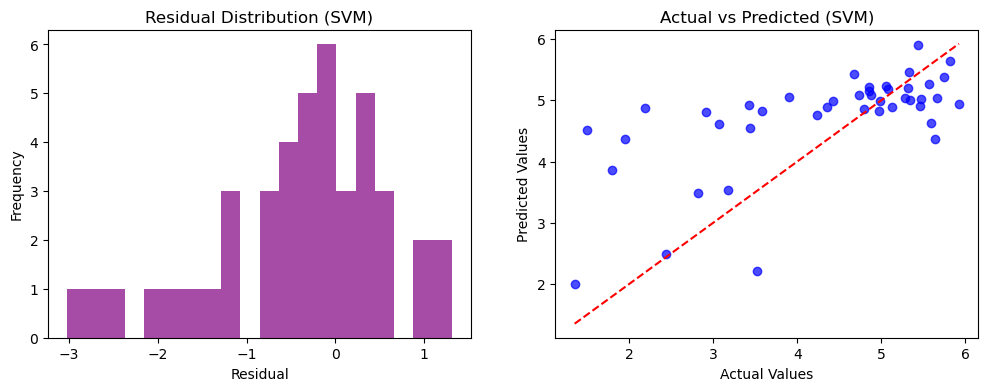

In [5]:
import matplotlib.pyplot as plt

# 计算残差
residuals = y_test - svr_best_model.predict(X_test)
plt.figure(figsize=(12, 4))

# 残差分布图
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, color='purple', alpha=0.7)
plt.title('Residual Distribution (SVM)')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# 实际值 vs 预测值
plt.subplot(1, 2, 2)
plt.scatter(y_test, svr_best_model.predict(X_test), alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted (SVM)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


## 随机森林

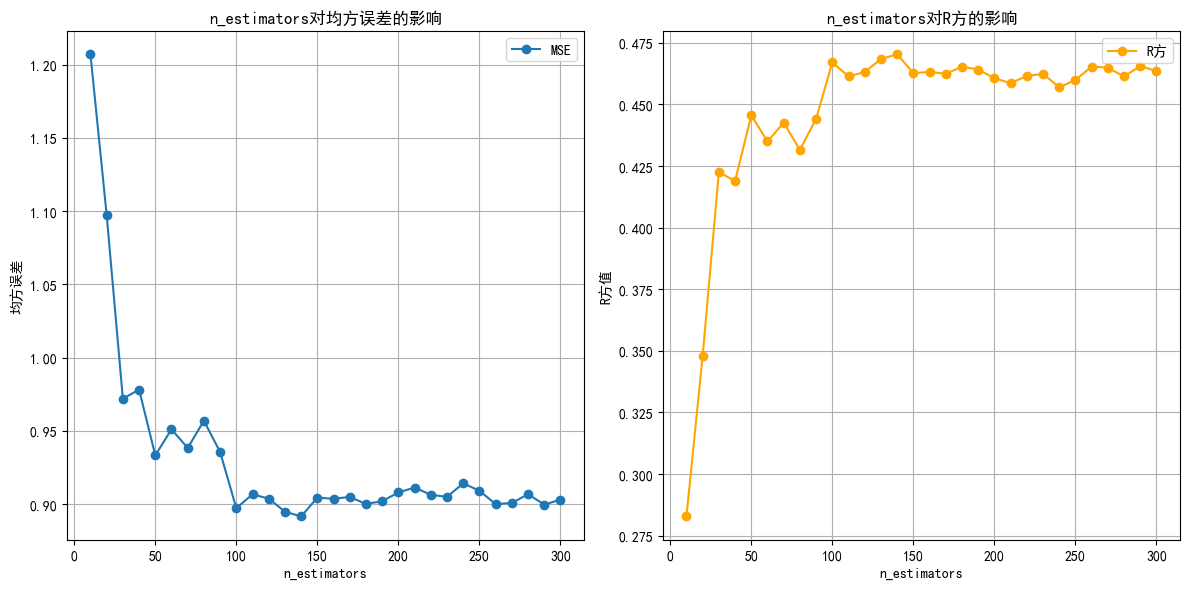

In [6]:
# 定义不同的 n_estimators 阶段
n_estimators_range = range(10, 310, 10)
mse_list = []
r2_list = []

# 遍历 n_estimators
for n in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # 计算性能指标
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)

# 可视化 n_estimators 对模型性能的影响
plt.figure(figsize=(12, 6))
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制 MSE 变化曲线
plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, mse_list, marker='o', label='MSE')
plt.xlabel('n_estimators')
plt.ylabel('均方误差')
plt.title('n_estimators对均方误差的影响')
plt.grid(True)
plt.legend()

# 绘制 R² 变化曲线
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, r2_list, marker='o', color='orange', label='R方')
plt.xlabel('n_estimators')
plt.ylabel('R方值')
plt.title('n_estimators对R方的影响')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# 固定最佳的 n_estimators 值
best_n_estimators = 100  # 根据之前的实验结果

# 定义参数网格
rf_param_grid = {
    'max_depth': range(3, 10, 1),
    'min_samples_leaf': range(1, 10, 1),
    'min_samples_split': range(2, 10, 1),
    
}

# 随机森林自动调参
rf = RandomForestRegressor(n_estimators = best_n_estimators, random_state=42)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# 获取最佳参数和评分
rf_best_params = rf_grid_search.best_params_
rf_best_score = -rf_grid_search.best_score_

# 使用最佳参数训练最终模型
rf_best_model = rf_grid_search.best_estimator_

# 在测试集上预测
rf_y_pred = rf_best_model.predict(X_test)

# 测试集性能评估
rf_test_mse = mean_squared_error(y_test, rf_y_pred)
rf_test_r2 = r2_score(y_test, rf_y_pred)

# 打印结果
print("最佳参数:", rf_best_params)
print("训练集最佳 MSE:", rf_best_score)
print("测试集 MSE:", rf_test_mse)
print("测试集 R²:", rf_test_r2)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits
最佳参数: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}
训练集最佳 MSE: 1.3453615677628938
测试集 MSE: 0.7408595210707926
测试集 R²: 0.5598201247383348


特征重要性：
  Feature  Importance
0    目标金额    0.654121
1    更新数量    0.166162
4     清晰度    0.062286
5      亮度    0.041868
6     相似度    0.036206
7    人脸总数    0.022218
2  回报选项数量    0.017139
3   是否有视频    0.000000


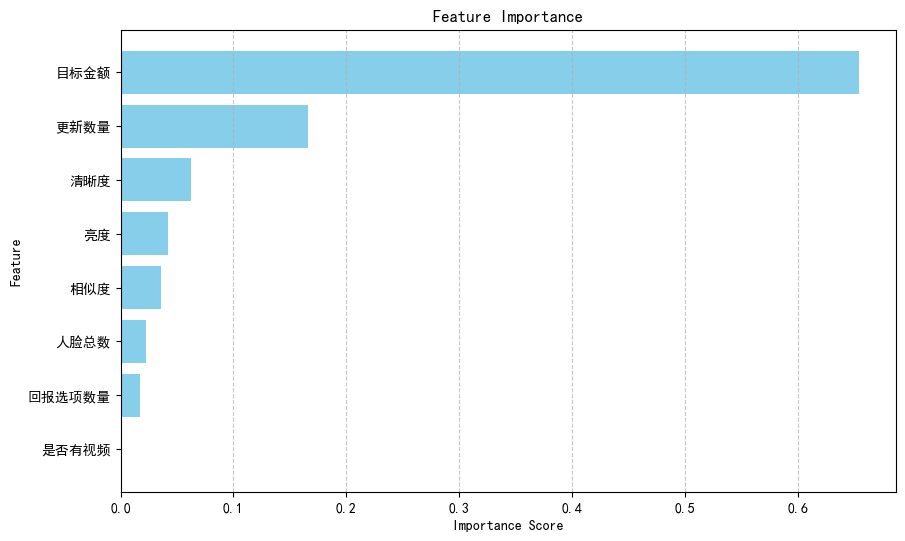

In [8]:
# 特征重要性
feature_importances = rf_best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("特征重要性：")
print(importance_df)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.show()


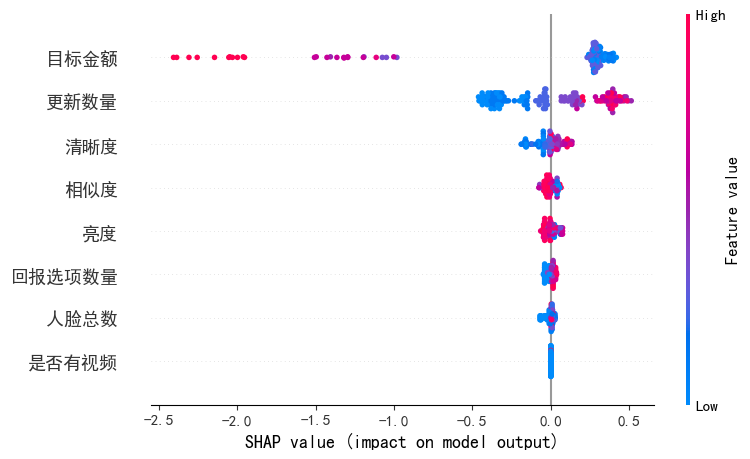

In [19]:
import shap

# 使用 TreeExplainer 计算 SHAP 值
explainer = shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_train)

# 绘制 SHAP summary plot
shap.summary_plot(shap_values, X_train)



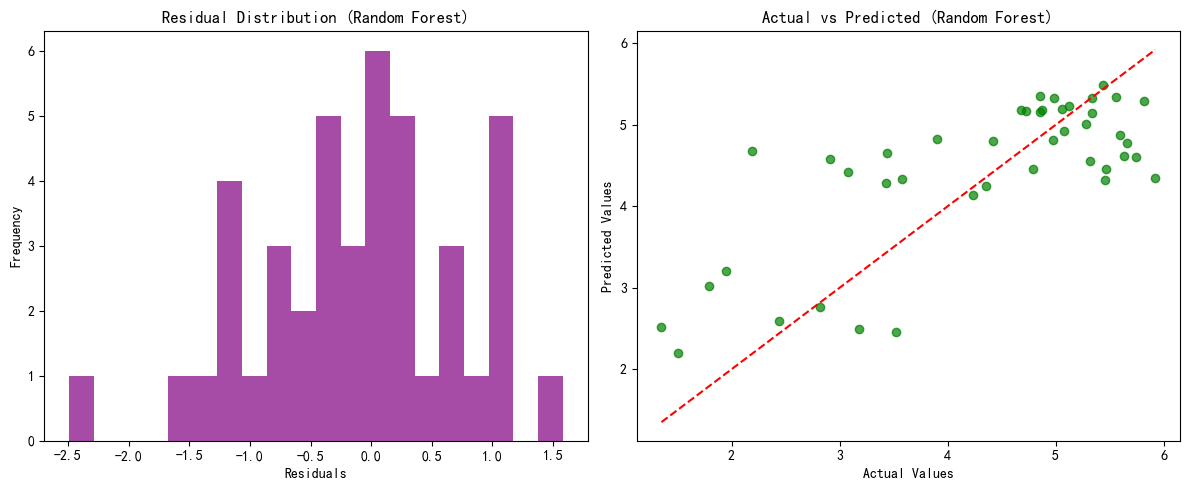

In [9]:
# 残差分析
residuals = y_test - rf_y_pred

plt.figure(figsize=(12, 5))

# 残差分布
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, color='purple', alpha=0.7)
plt.title('Residual Distribution (Random Forest)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# 实际值 vs 预测值
plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_y_pred, alpha=0.7, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

## XGBoost

In [23]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 定义参数网格
xgb_param_grid = {
    'n_estimators': range(10, 201, 10),       # 树的数量范围
    'max_depth': range(3, 10, 1),             # 树的深度范围
    'colsample_bytree': np.arange(0.3, 0.6, 0.05),  # 特征采样比例
    'gamma': range(0, 5),                     # 正则化参数
    'learning_rate': np.arange(0.01, 0.2, 0.05),  # 学习率
}

# 初始化XGBoost模型
xgb_model = xgb.XGBRegressor(random_state=42)

# 网格搜索参数
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=3,        # 3折交叉验证
    scoring='neg_mean_squared_error',
    n_jobs=-1,   # 使用所有可用CPU核心
    verbose=1
)

# 开始搜索
xgb_grid_search.fit(X_train, y_train)

# 获取最佳参数和评分
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = -xgb_grid_search.best_score_

# 使用最佳参数训练最终模型
xgb_best_model = xgb_grid_search.best_estimator_

# 在测试集上预测
xgb_y_pred = xgb_best_model.predict(X_test)

# 测试集性能评估
xgb_test_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_test_r2 = r2_score(y_test, xgb_y_pred)

# 输出结果
print("最佳参数:", xgb_best_params)
print("训练集最佳 MSE:", xgb_best_score)
print("测试集 MSE:", xgb_test_mse)
print("测试集 R²:", xgb_test_r2)


Fitting 3 folds for each of 16800 candidates, totalling 50400 fits
最佳参数: {'colsample_bytree': 0.49999999999999994, 'gamma': 2, 'learning_rate': 0.060000000000000005, 'max_depth': 9, 'n_estimators': 60}
训练集最佳 MSE: 1.336460717542287
测试集 MSE: 0.8525874841004345
测试集 R²: 0.493437228344501


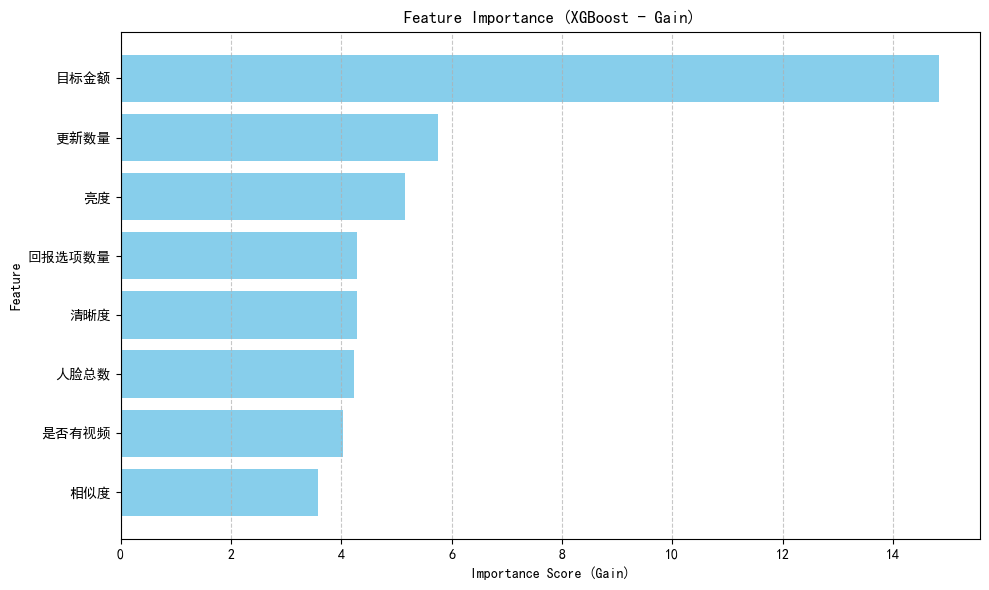

In [25]:
# 提取基于 weight 的特征重要性
xgb_feature_importances = xgb_best_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(xgb_feature_importances.keys()),
    'Importance': list(xgb_feature_importances.values())
}).sort_values(by='Importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 翻转 Y 轴以使最高特征在顶部
plt.title('Feature Importance (XGBoost - Gain)')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # 添加网格线增加清晰度
plt.tight_layout()
plt.show()


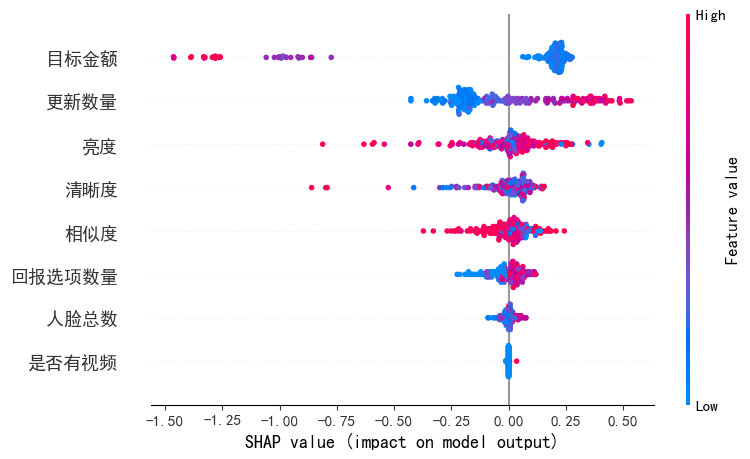

In [20]:
import shap

# 假设 xgb 是训练好的 XGBoost 模型
explainer = shap.TreeExplainer(xgb_best_model)
shap_values = explainer.shap_values(X)

# 绘制 SHAP summary plot
shap.summary_plot(shap_values, X)



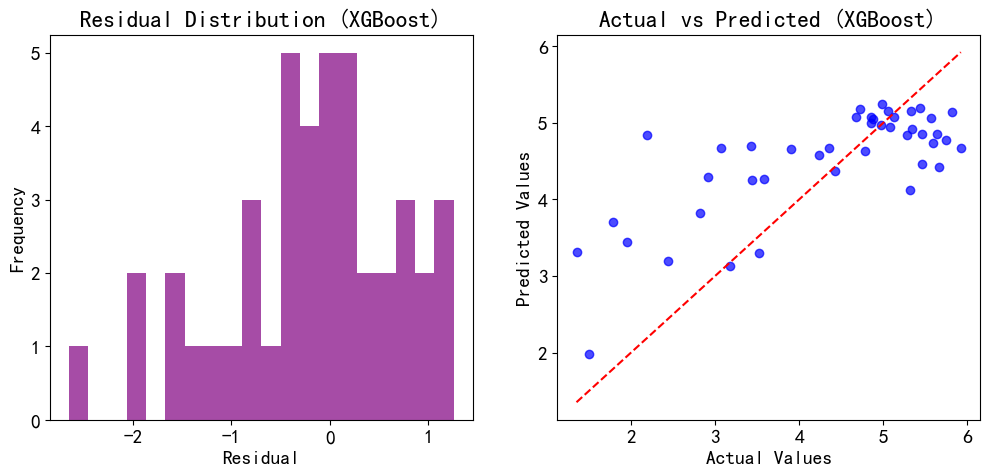

In [39]:
# 计算残差
residuals = y_test - xgb_best_model.predict(X_test)

plt.figure(figsize=(12, 5))
# 字体大小设置
plt.rcParams.update({'font.size': 14})
# 残差分布图
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, color='purple', alpha=0.7)
plt.title('Residual Distribution (XGBoost)')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# 实际值 vs 预测值
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_best_model.predict(X_test), alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted (XGBoost)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
